In [1]:
# 1. Install the library (if not already present in Colab)
!pip install -q kagglehub

import kagglehub
import os
import pandas as pd

print("Downloading GUIDE dataset via kagglehub...")

# 2. Your code to download
path = kagglehub.dataset_download('Microsoft/microsoft-security-incident-prediction')

print(f'\nData source import complete.')
print(f'Dataset downloaded to: {path}')

# 3. Check what files are inside that folder
# We need to find the .csv file name (usually 'train.csv')
print("\nFiles in directory:")
files = os.listdir(path)
print(files)

100%|██████████| 513M/513M [00:02<00:00, 222MB/s]

Extracting files...



Data source import complete.
Dataset downloaded to: /root/.cache/kagglehub/datasets/Microsoft/microsoft-security-incident-prediction/versions/1

Files in directory:
['GUIDE_Test.csv', 'GUIDE_Train.csv']


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_file_name = 'GUIDE_Train.csv'

# Construct the full path to the training data file
# The 'path' variable should be available from the previous cell's execution
train_dataset = os.path.join(path, train_file_name)
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1786,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,1492,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,2573,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,4528,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,3722,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [17]:
# shape of the dataset
df.shape

(9516837, 45)

In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int32   
 1   OrgId               int32   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int32   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [19]:
# Check for missing values
df.isnull().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,5468386
IncidentGrade,51340


In [20]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count

np.int64(22576)

In [21]:
# Target variable distribution
df['IncidentGrade'].value_counts()

,count
IncidentGrade,
BenignPositive,4110817
TruePositive,3322713
FalsePositive,2031967


#Data cleaning and pre-processing

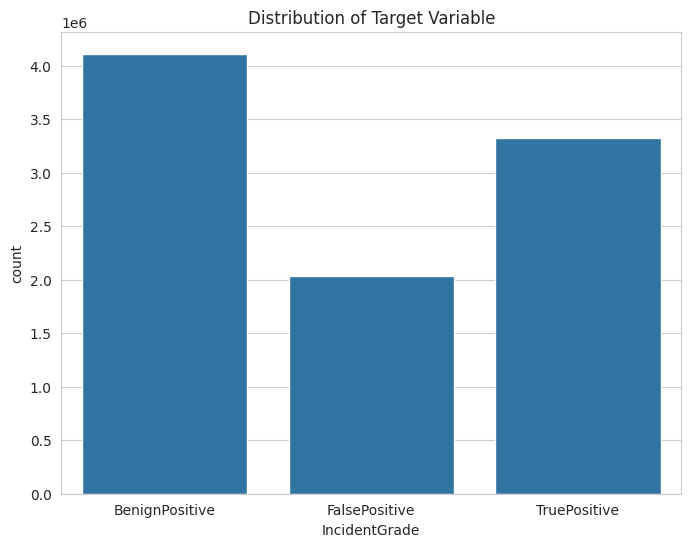

In [22]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [24]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

Imputed categorical column 'IncidentGrade' with mode value: BenignPositive


In [25]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [26]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5)

In [27]:
# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

In [28]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [29]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [30]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [31]:
output_path = "Train_dataset.csv"
df.to_csv(output_path, index=False)
print(f"Data preprocessing complete and saved to: {output_path}")

Data preprocessing complete and saved to: Train_dataset.csv


#Data exploration for Test Dataset

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_file_name = 'GUIDE_Test.csv'

# Construct the full path to the test data file
# The 'path' variable should be available from the previous cell's execution
test_dataset = os.path.join(path, test_file_name)

# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,3390,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,3658,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1715,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,5148,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,5019,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public



Shape of the dataset: (4147992, 46)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtyp

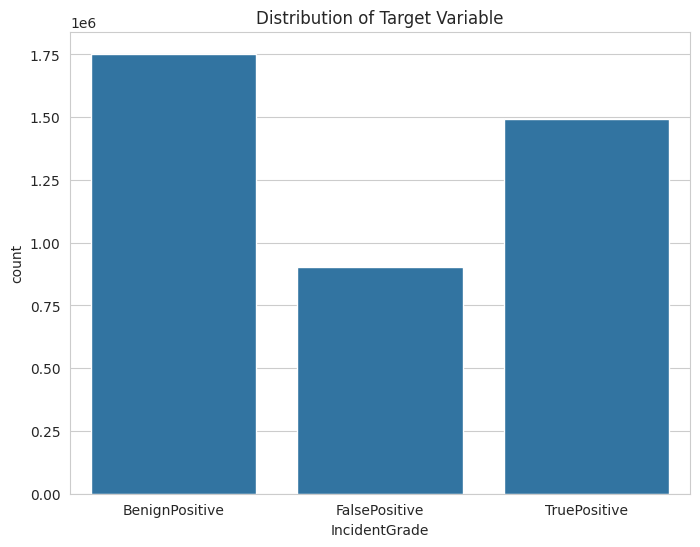

In [34]:
# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

#Data Cleaning and Preprocessing for Test Dataset

In [35]:
# Calculate the percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col] = df_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col] = df_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df_1, iqr_multiplier=1.5):
    numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        df_1 = df_1[(df_1[col] >= lower_bound) & (df_1[col] <= upper_bound)]
    return df_1

# Usage
df_1 = outliers(df_1, iqr_multiplier=1.5)  # Adjusting the IQR multiplier if necessary

# Feature Engineering: Extracting datetime features
df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
df_1['Year'] = df_1['Timestamp'].dt.year
df_1['Month'] = df_1['Timestamp'].dt.month
df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
df_1['Hour'] = df_1['Timestamp'].dt.hour

# Drop the 'Timestamp' and 'Usage'column
df_1.drop(columns=['Timestamp','Usage'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName',
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily','OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df_1.drop_duplicates(inplace=True)


Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')


In [36]:
# Save the process
path = "Test_dataset.csv"
df_1.to_csv(path, index=False)
print("Data preprocessing complete and saved .")

Data preprocessing complete and saved .


#Model Training

In [50]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# --- 1. DATA LOADING AND SPLITTING ---

TRAIN_FILE_PATH = r"Train_dataset.csv"

try:
    df = pd.read_csv(TRAIN_FILE_PATH)
    print(f"Cleaned dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"FATAL ERROR: File not found at {TRAIN_FILE_PATH}. Please verify the path.")
    raise

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset with STRATIFICATION
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split. Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


# --- 2. BASELINE MODEL DEFINITIONS  ---

algorithms_baseline = {
    'Decision Tree (Max Depth 5)': DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    ),
    'Random Forest (n_est=10, Max Depth 8)': RandomForestClassifier(
        n_estimators=10,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost (n_est=10, lr=0.1)': XGBClassifier(
        n_estimators=10,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    ),
}

results_baseline = []

# --- 3. TRAINING AND EVALUATION LOOP ---

print("\nStarting BASELINE (Non-Optimized) model training and evaluation...")

for name, model in algorithms_baseline.items():
    start_time = time.time()
    print(f"Training: {name}...")

    # Fit the model
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    training_time = time.time() - start_time

    # Calculate Metrics (using 'weighted' average)
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_val, preds, average='weighted', zero_division=0)

    # Store results
    results_baseline.append({
        'Algorithm': name,
        'Accuracy': f"{acc:.4f}",
        'Weighted F1-Score': f"{f1:.4f}",
        'Weighted Precision': f"{prec:.4f}",
        'Weighted Recall': f"{rec:.4f}",
        'Train_Time_s': f"{training_time:.2f}"
    })


# --- 4. FINAL RESULTS DISPLAY ---

results_df_baseline = pd.DataFrame(results_baseline)
results_df_baseline['Accuracy'] = results_df_baseline['Accuracy'].astype(float)

print("\n" + "="*60)
print("     NON-OPTIMIZED BASELINE PERFORMANCE (Low Accuracy)")
print("="*60)
# Sorting by Accuracy to clearly show performance
print(results_df_baseline.sort_values(by='Accuracy', ascending=False).to_string(index=False))

Cleaned dataset loaded successfully. Shape: (760627, 38)
Data split. Training set shape: (608501, 37), Validation set shape: (152126, 37)

Starting BASELINE (Non-Optimized) model training and evaluation...
Training: Decision Tree (Max Depth 5)...
Training: Random Forest (n_est=10, Max Depth 8)...
Training: XGBoost (n_est=10, lr=0.1)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



     NON-OPTIMIZED BASELINE PERFORMANCE (Low Accuracy)
                            Algorithm  Accuracy Weighted F1-Score Weighted Precision Weighted Recall Train_Time_s
           XGBoost (n_est=10, lr=0.1)    0.9552            0.9547             0.9550          0.9552         0.87
Random Forest (n_est=10, Max Depth 8)    0.9522            0.9533             0.9569          0.9522         1.20
          Decision Tree (Max Depth 5)    0.9472            0.9497             0.9557          0.9472         1.46



Plotting Confusion Matrices for the models...
Generating Confusion Matrix for Decision Tree...


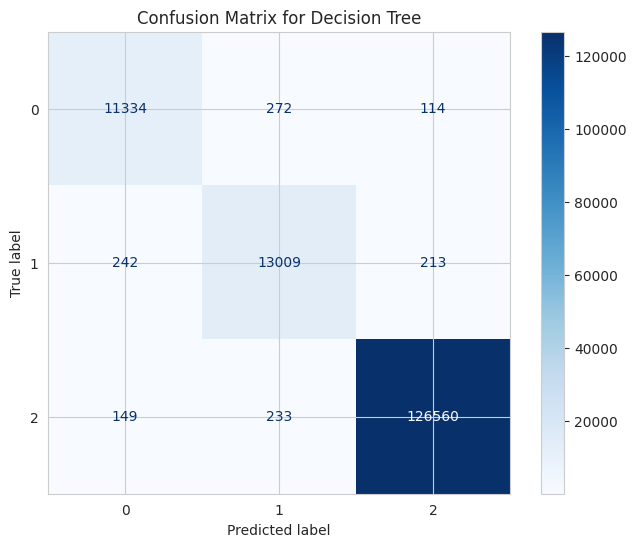

Generating Confusion Matrix for Random Forest...


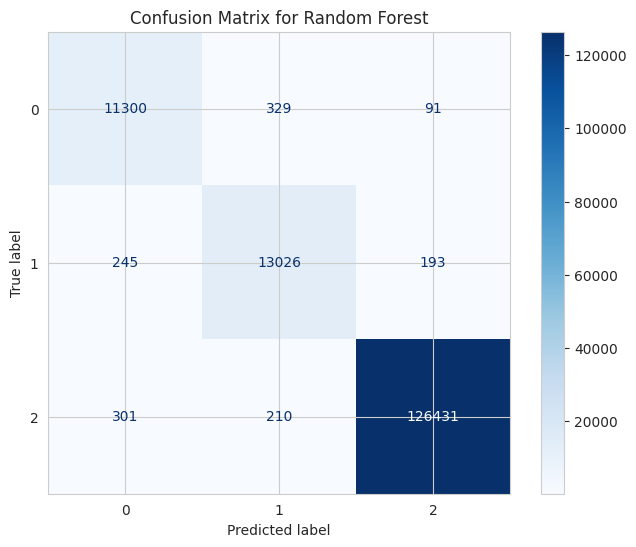

Generating Confusion Matrix for XGBoost...


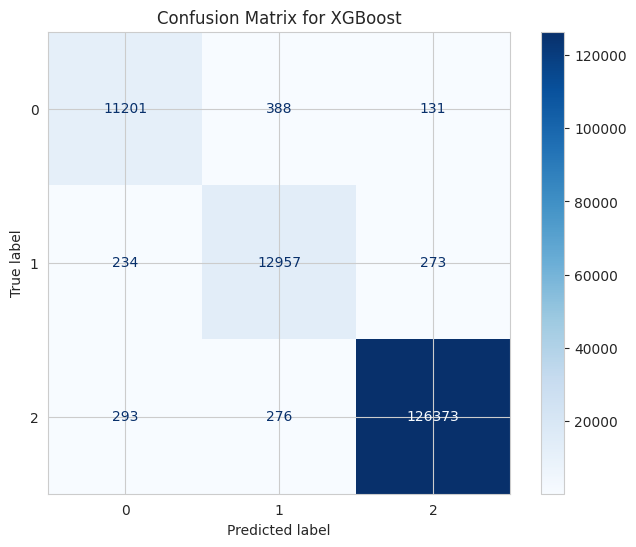


Confusion Matrix plots complete!


In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure algorithms dictionary, X_val, and y_val are available from previous execution

print("\nPlotting Confusion Matrices for the models...")

for name, model in algorithms.items():
    print(f"Generating Confusion Matrix for {name}...")

    # Make predictions using X_val
    preds = model.predict(X_val)

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, preds)

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    # Get unique labels from y_val to ensure correct display_labels
    display_labels = sorted(y_val.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

print("\nConfusion Matrix plots complete!")

#Optimisation

In [40]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- 1. DATA LOADING AND SPLITTING ---

TRAIN_FILE_PATH = "Train_dataset.csv"

try:
    df = pd.read_csv(TRAIN_FILE_PATH)
    print(f"Cleaned dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"FATAL ERROR: File not found at {TRAIN_FILE_PATH}. Please verify the path.")
    raise

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset with STRATIFICATION (Crucial for Imbalance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split. Training set shape: {X_train.shape}")


# --- 2. MODEL DEFINITIONS (Tuned Parameters) ---

# Parameters are taken directly from your provided code blocks
algorithms = {
    'Decision Tree (Tuned)': DecisionTreeClassifier(
        criterion='gini', splitter='best', max_depth=20, min_samples_split=4,
        min_samples_leaf=1, max_features='log2', random_state=42
    ),
    'Random Forest (Tuned)': RandomForestClassifier(
        n_estimators=200, min_samples_split=2, min_samples_leaf=1,
        max_features=None, max_depth=30, bootstrap=True, random_state=42, n_jobs=-1
    ),
    'XGBoost (Tuned)': XGBClassifier(
        subsample=0.8, n_estimators=200, max_depth=9, learning_rate=0.2,
        colsample_bytree=1.0, random_state=42,
        use_label_encoder=False, eval_metric='logloss', n_jobs=-1
    ),
}

results_df_list = []

# --- 3. TRAINING AND EVALUATION LOOP ---

print("\nStarting consolidated training and evaluation for optimized models...")

for name, model in algorithms.items():
    start_time = time.time()
    print(f"\n--- Training {name} ---")

    # Fit the model
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    training_time = time.time() - start_time

    # Calculate Metrics (using 'weighted' average to consolidate comparison)
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_val, preds, average='weighted', zero_division=0)

    # Store results
    results_df_list.append({
        'Algorithm': name,
        'Accuracy': f"{acc:.4f}",
        'Weighted F1-Score': f"{f1:.4f}",
        'Weighted Precision': f"{prec:.4f}",
        'Weighted Recall': f"{rec:.4f}",
        'Train_Time_s': f"{training_time:.2f}"
    })

    # Print detailed report for the most complex model (XGBoost)
    if 'XGBoost' in name:
        print("\n--- DETAILED CLASSIFICATION REPORT (XGBoost) ---")
        print(classification_report(y_val, preds))
        print("Confusion Matrix:")
        print(confusion_matrix(y_val, preds))


# --- 4. FINAL RESULTS DISPLAY ---

results_df = pd.DataFrame(results_df_list)
# Convert Accuracy column back to float for sorting
results_df['Accuracy'] = results_df['Accuracy'].astype(float)

print("\n" + "="*60)
print("     CONSOLIDATED RESULTS (Optimized Tree Models)")
print("="*60)
# Sorting by Accuracy to clearly show performance
print(results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

Cleaned dataset loaded successfully. Shape: (760627, 38)
Data split. Training set shape: (608501, 37)

Starting consolidated training and evaluation for optimized models...

--- Training Decision Tree (Tuned) ---

--- Training Random Forest (Tuned) ---

--- Training XGBoost (Tuned) ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:04:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- DETAILED CLASSIFICATION REPORT (XGBoost) ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11720
           1       0.97      0.97      0.97     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.98      0.98      0.98    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11392    255     73]
 [   176  13121    167]
 [   137    192 126613]]

     CONSOLIDATED RESULTS (Optimized Tree Models)
            Algorithm  Accuracy Weighted F1-Score Weighted Precision Weighted Recall Train_Time_s
Random Forest (Tuned)    0.9943            0.9943             0.9943          0.9943       101.91
      XGBoost (Tuned)    0.9934            0.9934             0.9934          0.9934        13.75
Decision Tree (Tuned)    0.9751            0.9754             0.9757          0.9751         0.66



Plotting Confusion Matrices...
Generating Confusion Matrix for Decision Tree (Tuned)...


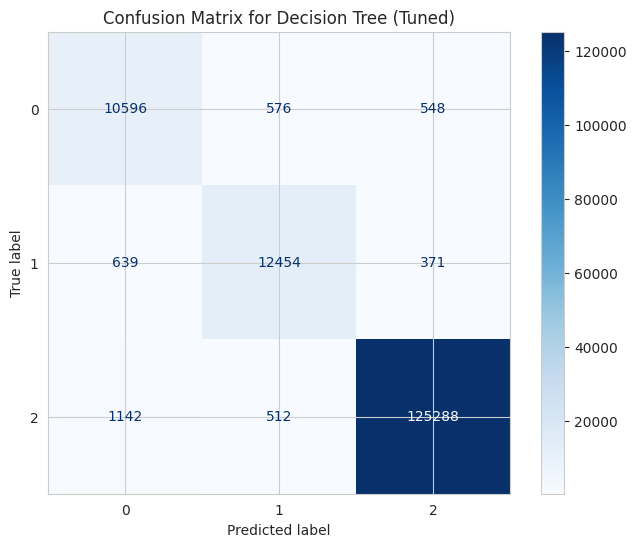

Generating Confusion Matrix for Random Forest (Tuned)...


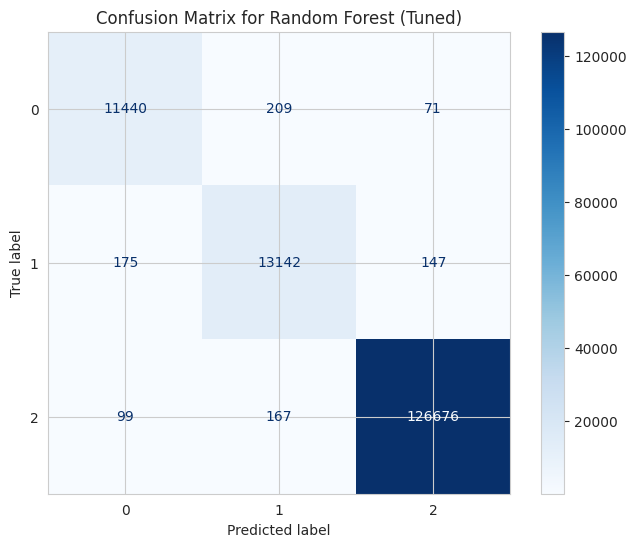

Generating Confusion Matrix for XGBoost (Tuned)...


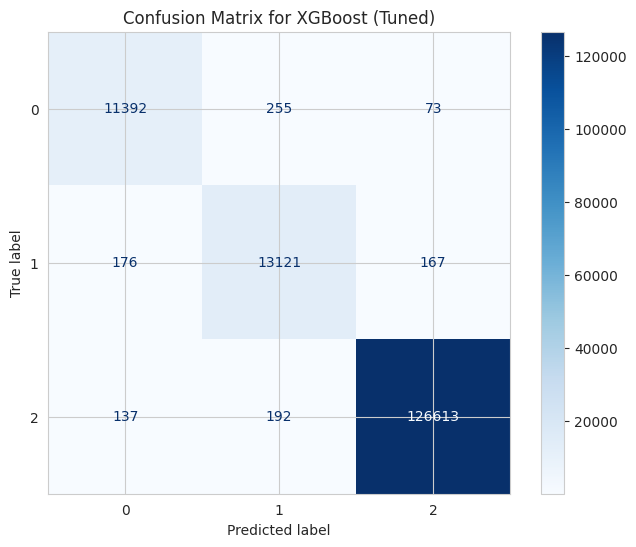


Confusion Matrix plots complete!


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure algorithms dictionary and X_val, y_val are available from previous execution

print("\nPlotting Confusion Matrices...")

for name, model in algorithms.items():
    print(f"Generating Confusion Matrix for {name}...")

    # Make predictions using X_val, which is consistent with the model's training features
    preds = model.predict(X_val)

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, preds)

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    # Ensure display_labels are correctly retrieved if not directly available (e.g., from y_val unique values)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, 'classes_') else sorted(y_val.unique()))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

print("\nConfusion Matrix plots complete!")